In [13]:

from parse_signal import load_psg, load_neuroon

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal, fftpack
from numpy.fft import fft, ifft, fft2, ifft2, fftshift
from itertools import tee
%matplotlib inline
%load_ext autoreload
%autoreload 2
plt.style.use('ggplot')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
def shift_test(a, b, hour = 'first'):

    # Signal convolution correlation
    corr1 = signal.correlate(a,b, mode = 'same')
    # Positive lag means b starts after a, negative lag means a starts after b
   
    lag1 = int(len(a) / 2)  - np.argmax(corr1)
    v = np.arange((-len(a))/2 +1, len(a)/2 +1, 1)

    # FFT convolution correlation
    lag2, corr2 = compute_shift(a, b)
    
    # previous method used
    corr3 = correlate_with_time_shift(a,b)
    lag3 = np.argmax(corr3)
    
    #Pandas based method
    corr4 = pandas_crosscorr(a, b,min_lag =0,  max_lag=100 * 60 * 30)
    lag4 = np.argmax(corr4)
    
    fig, axes = plt.subplots(5, sharex = False, figsize = (20,40))
    for ax in axes:
        ax.tick_params(axis='both', which='major', labelsize=8)
        ax.tick_params(axis='both', which='minor', labelsize=8)
        ax.spines['top'].set_visible(False)
        
    # fig.suptitle('neuroon signal delayed')
    axes[0].plot(a, c = 'r', alpha = 0.5, label = 'neuroon')
    axes[0].plot(b, c = 'b', alpha = 0.5, label = 'psg')
    axes[0].legend()
    
    
    
    axes[1].plot(v,corr1)
    axes[1].set_xlim(v[0], v[-1])
    axes[1].set_title('offset found at %i seconds'%int(lag1 / 100), fontsize = 10)


        

    axes[2].plot(v,corr2)
    axes[2].set_xlim(v[0], v[-1])
    axes[2].set_title('offset found at %i seconds'%int(lag2 / 100), fontsize = 10)

    
    

    axes[3].plot(corr3)
    
    axes[3].set_title('offset found at %i seconds'%int(-lag3 / 100), fontsize = 10)

    axes[3].set_xlim(0, len(corr3))

    axes[0].set_ylabel('correlated signals')
    axes[1].set_ylabel('correlation using\n signal convolution')
    axes[2].set_ylabel('correlation using\n fft convolution')
    axes[3].set_ylabel('correlation using\n moving window')
    axes[4].set_ylabel('correlation using\n pandas shift')
    axes[4].set_xlabel('offset in sample number')
    

    axes[4].plot(corr4)
    axes[4].set_title('offset found at %i seconds'%int(-lag4 / 100), fontsize = 10)

    print(lag1)
    print(lag2)
    print(lag3)
    print(lag4)
    plt.tight_layout()
    
    # fig.savefig('figures/crosscorrelation/crosscorr%s.pdf'%hour) 
    

In [15]:
# Different cross correaltion functions used for testing
def cross_correlation_using_fft(x, y):
    f1 = fft(x)
    f2 = fft(np.flipud(y))
    cc = np.real(ifft(f1 * f2))
    return fftshift(cc)
 
# shift < 0 means that y starts 'shift' time steps before x # shift > 0 means that y starts 'shift' time steps after x
def compute_shift(x, y):
    assert len(x) == len(y)
    c = cross_correlation_using_fft(x, y)
    assert len(c) == len(x)
    zero_index = int(len(x) / 2) - 1
    shift = zero_index - np.argmax(c)
    return shift,c
    

def correlate_with_time_shift(first_signal, second_signal):

    max_shift = len(first_signal)/2# 35 min shift

    #window_length = 100 * 60* 20 #20 min window for 100hz signal 
    window_length = int(len(first_signal) * 0.4) #20 min window for 100hz signal 
    
    
    correlation_array = np.zeros(max_shift)
  
    for i in range(max_shift):
        correlation = np.correlate(
        second_signal[i :i  + window_length], first_signal[0 : window_length]
      
        )
        correlation_array[i] = correlation
    return correlation_array

def pandas_crosscorr(datax, datay, min_lag = 0,  max_lag=0):

    lags = np.arange(min_lag, max_lag, 1)
    
    corrs = np.zeros(len(lags))
    for idx,  lag in enumerate(lags):
        #  print(idx)
        c = datax.corr(datay.shift(lag))
        corrs[idx] = c
        
    return np.array(corrs) 

def pairwise(iterable):
    """Used to iterate over a list elements organized in pairs"""
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

In [16]:
def iterate_hours():
    
    psg_signal =  load_psg('F3-A2')
    neuroon_signal =  load_neuroon()
    
    psg_10 = psg_signal.resample('10ms').mean()
    neuroon_10 = neuroon_signal.resample('10ms').mean()
    
    for start, end in pairwise([ '23:00','00:00', '01:00', '02:00', '03:00', '04:00', '05:00', '06:00']):
        print('start: %s'%start)
        psg_cut = psg_10.between_time(start, end)
        neuroon_cut = neuroon_10.between_time(start, end)
            
        shift_test(neuroon_cut ,psg_cut, hour = start)


start: 23:00
-16045
-16045
86728
16045
start: 00:00
-16047
-16047
102463
16047
start: 01:00
-16050
-16050
2946
16050
start: 02:00
-16053
-16053
95730
16053
start: 03:00
-16057
-16057
153445
16057
start: 04:00
-16061
-16061
146168
16061
start: 05:00
-16153
-16153
45475
16153


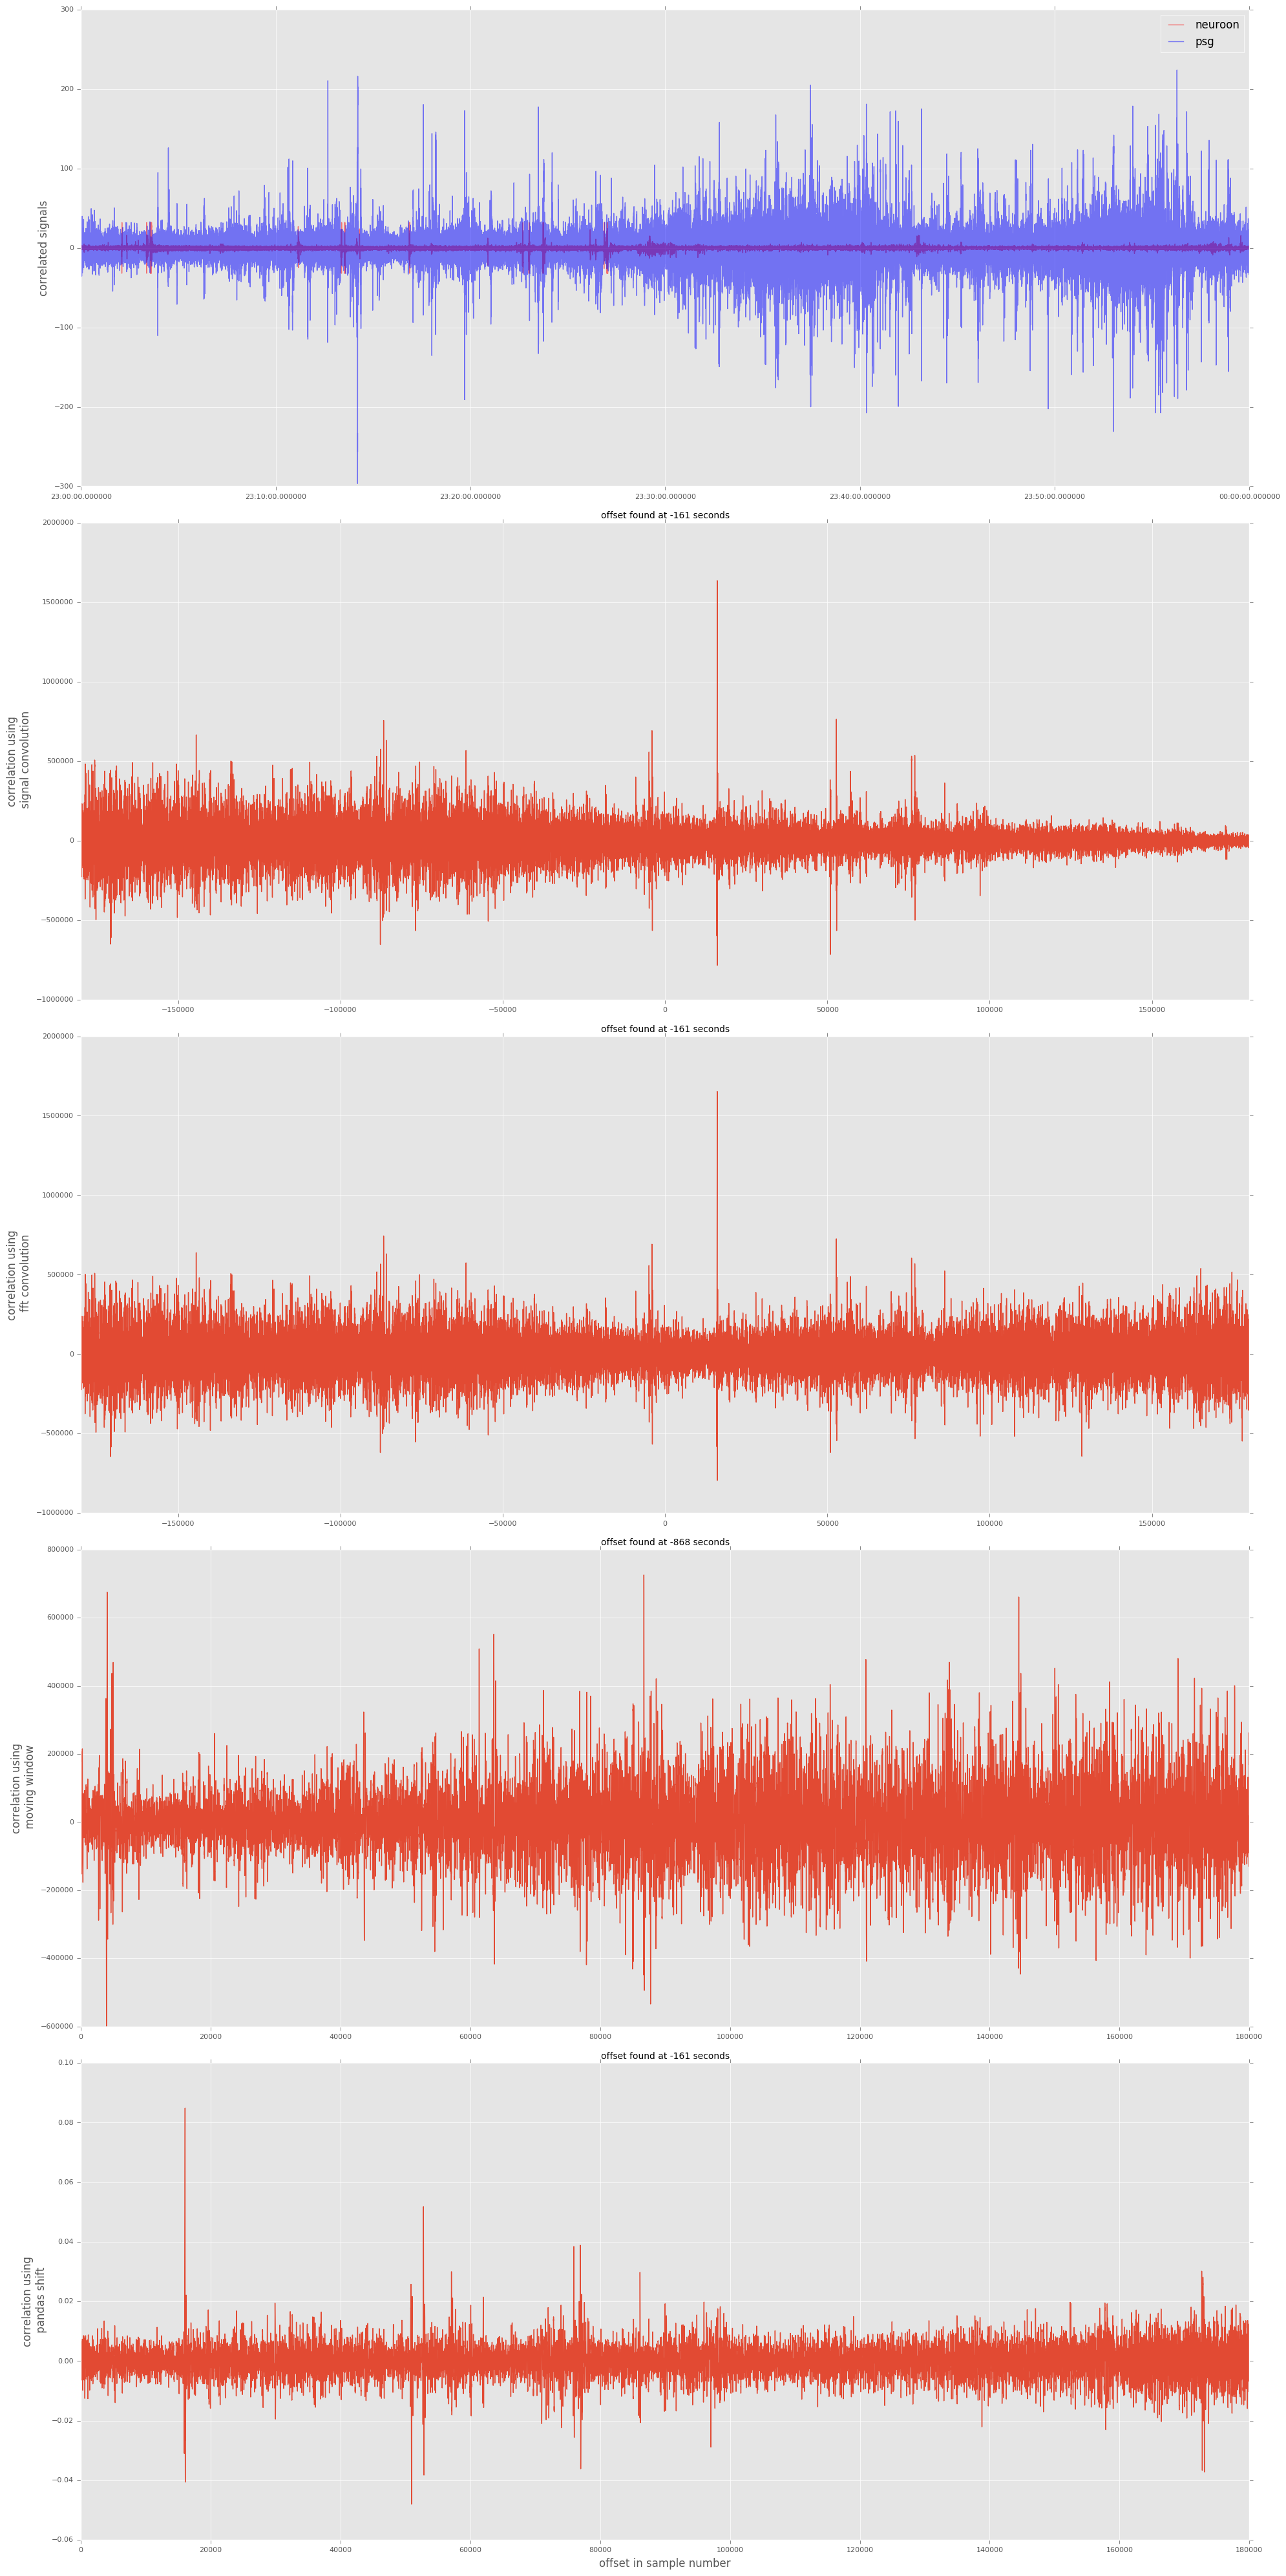

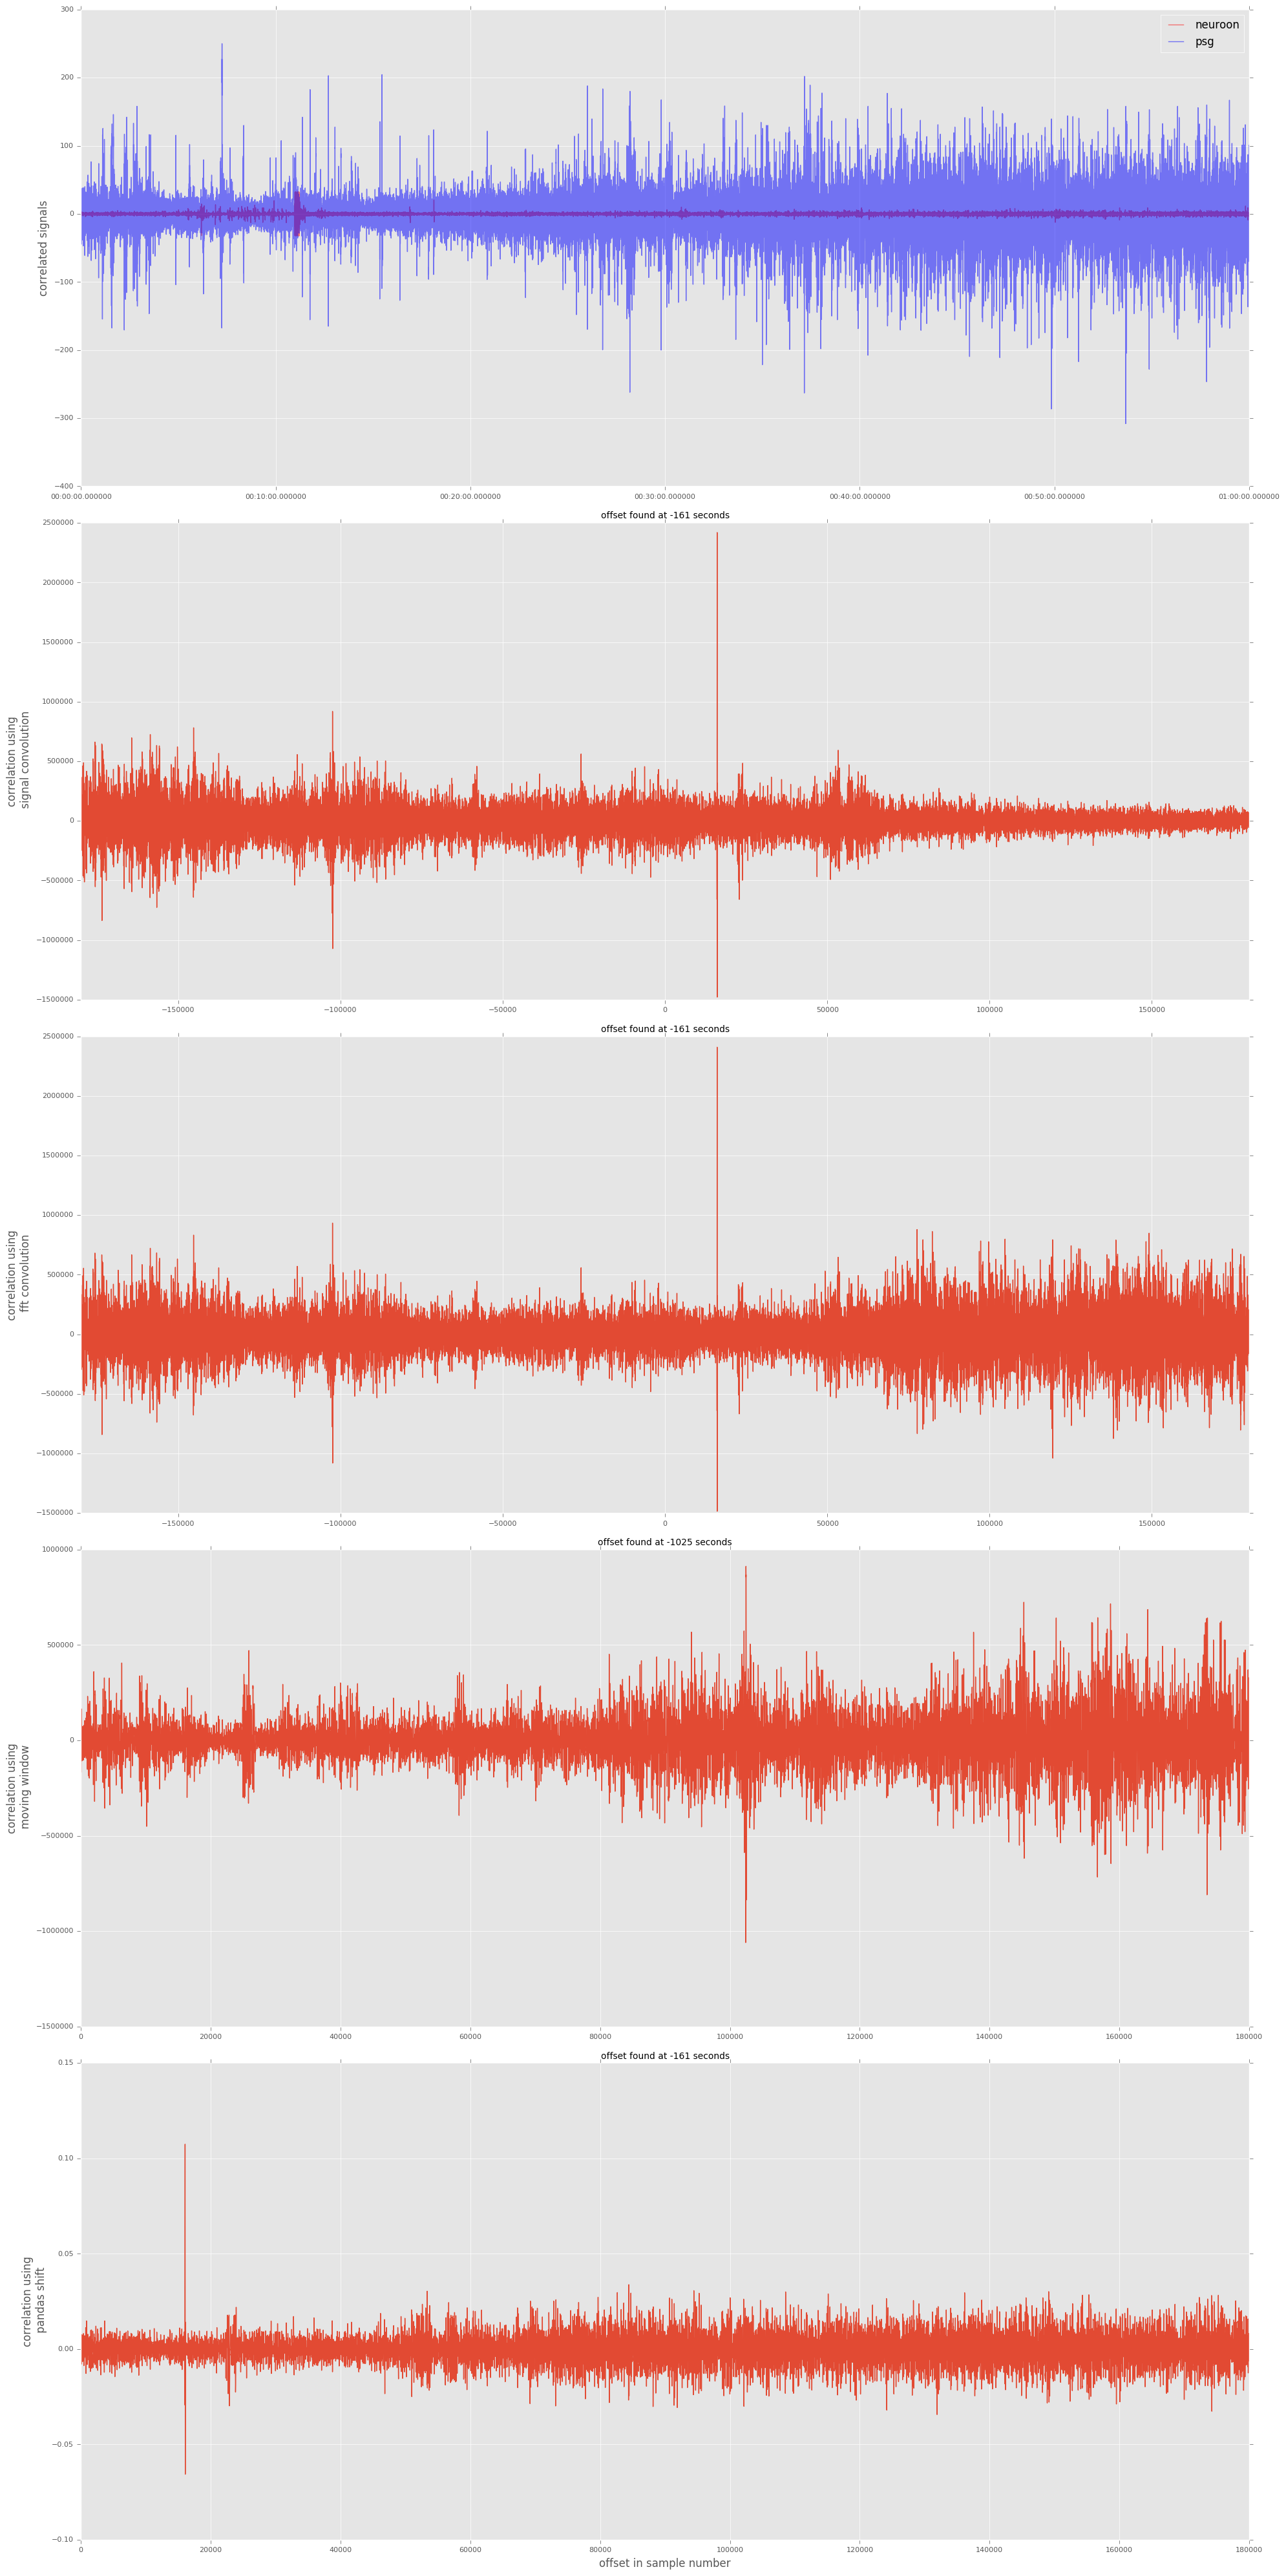

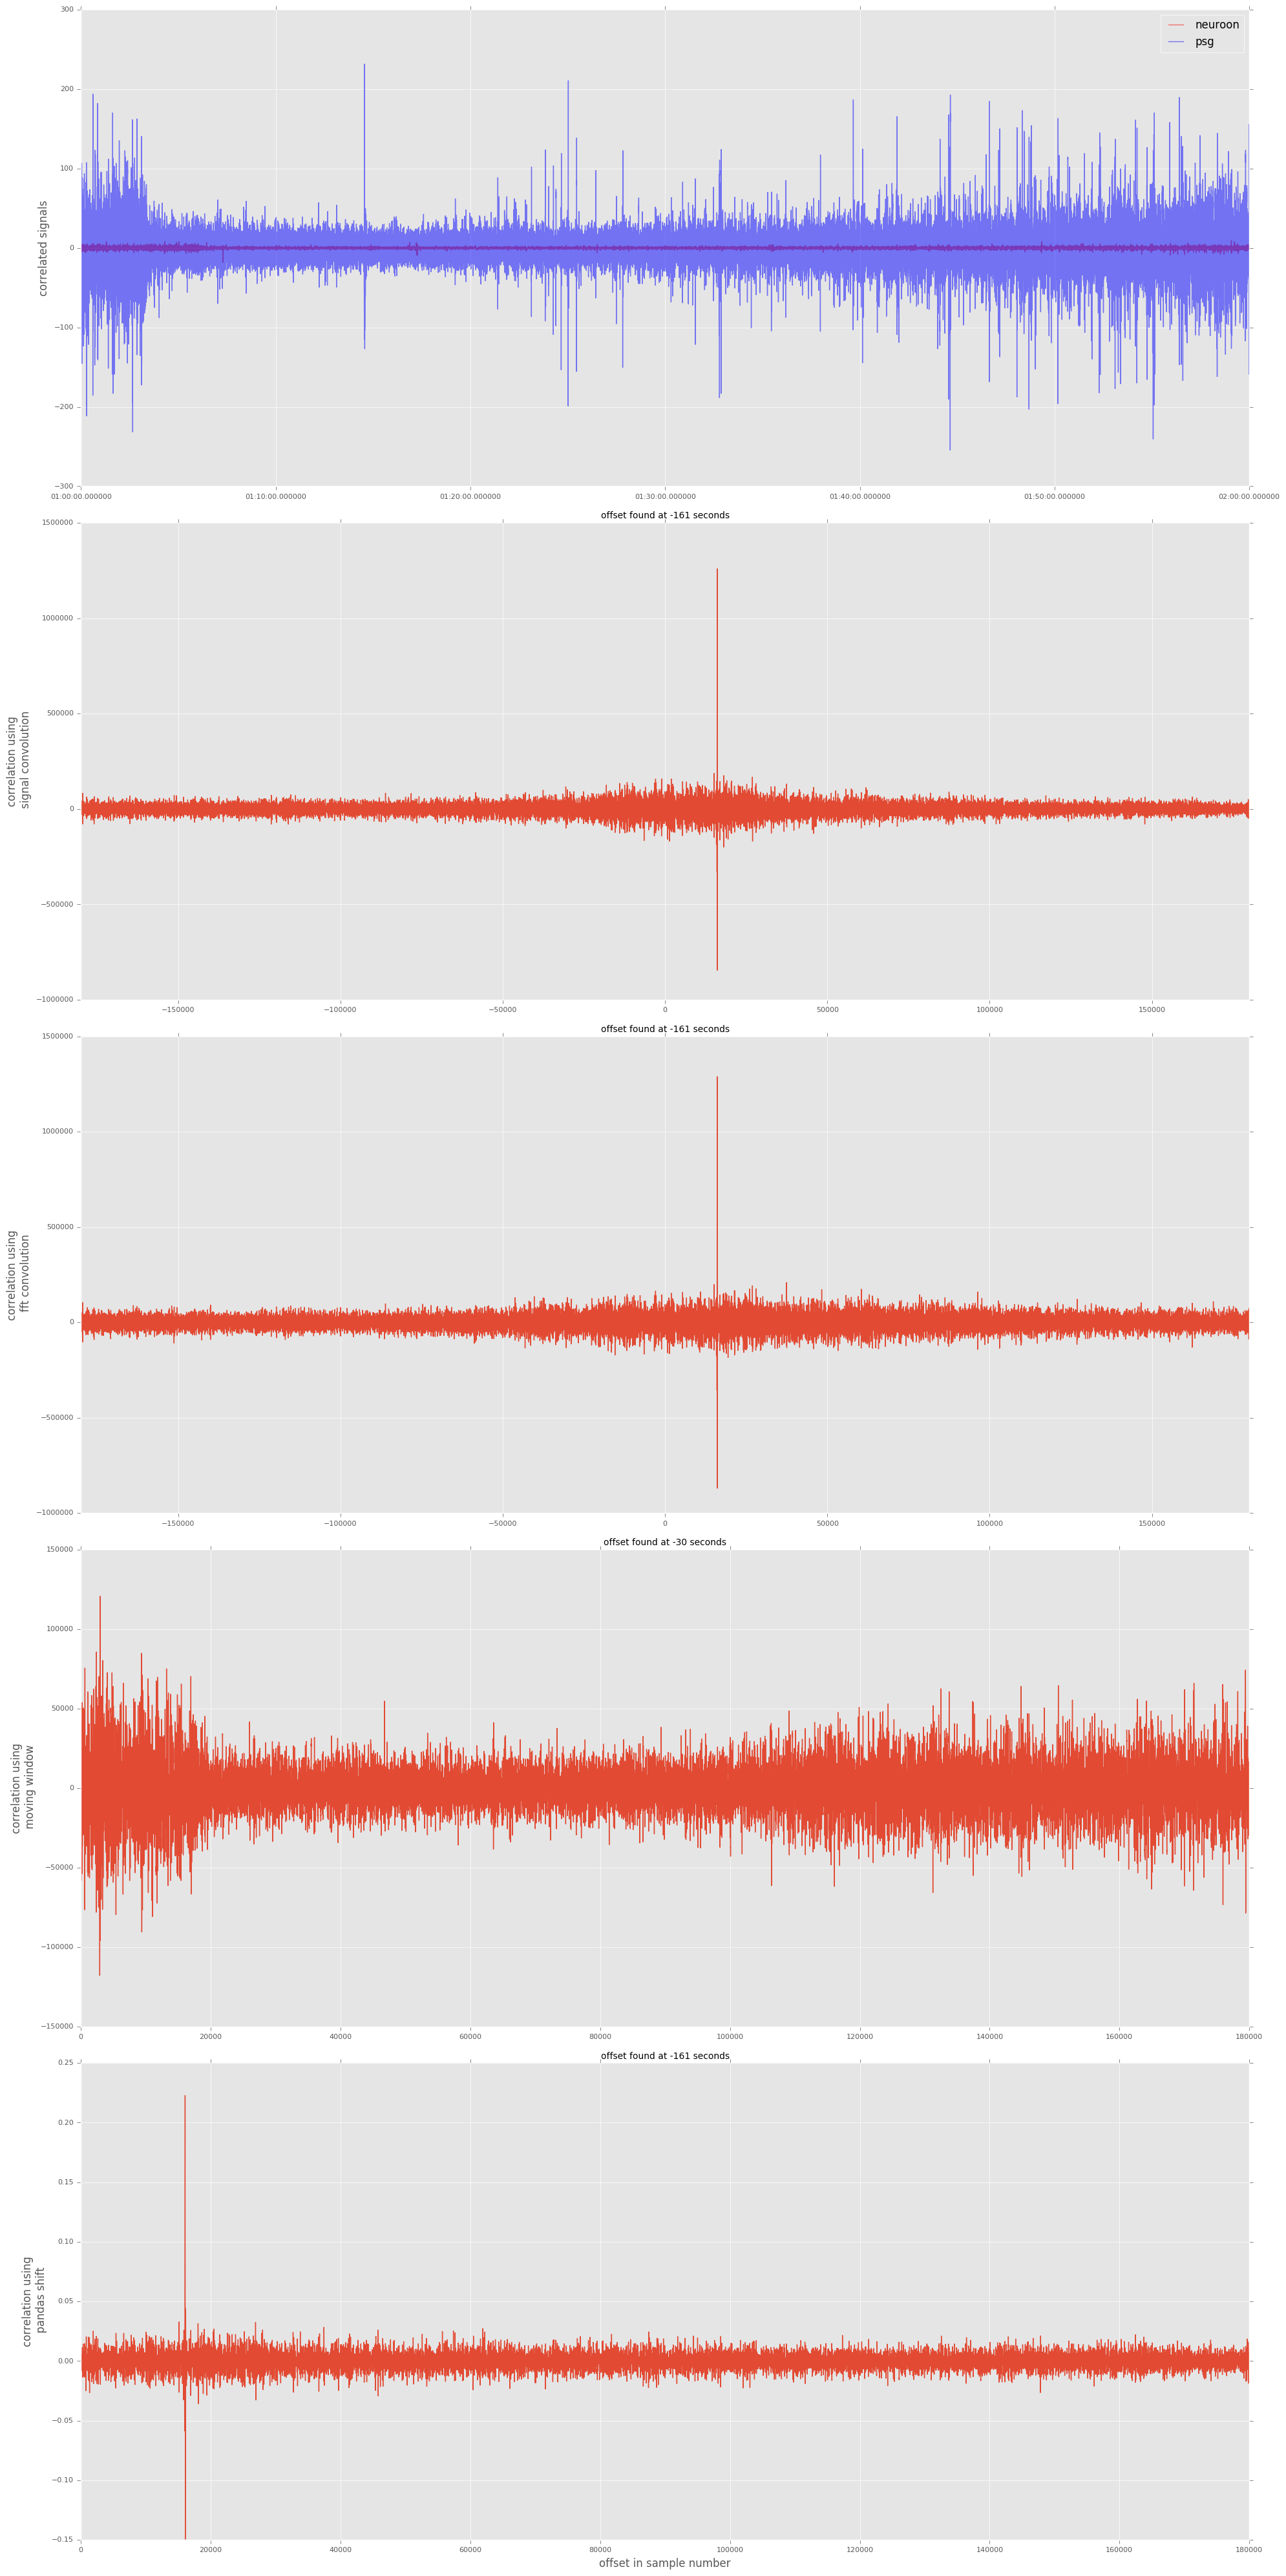

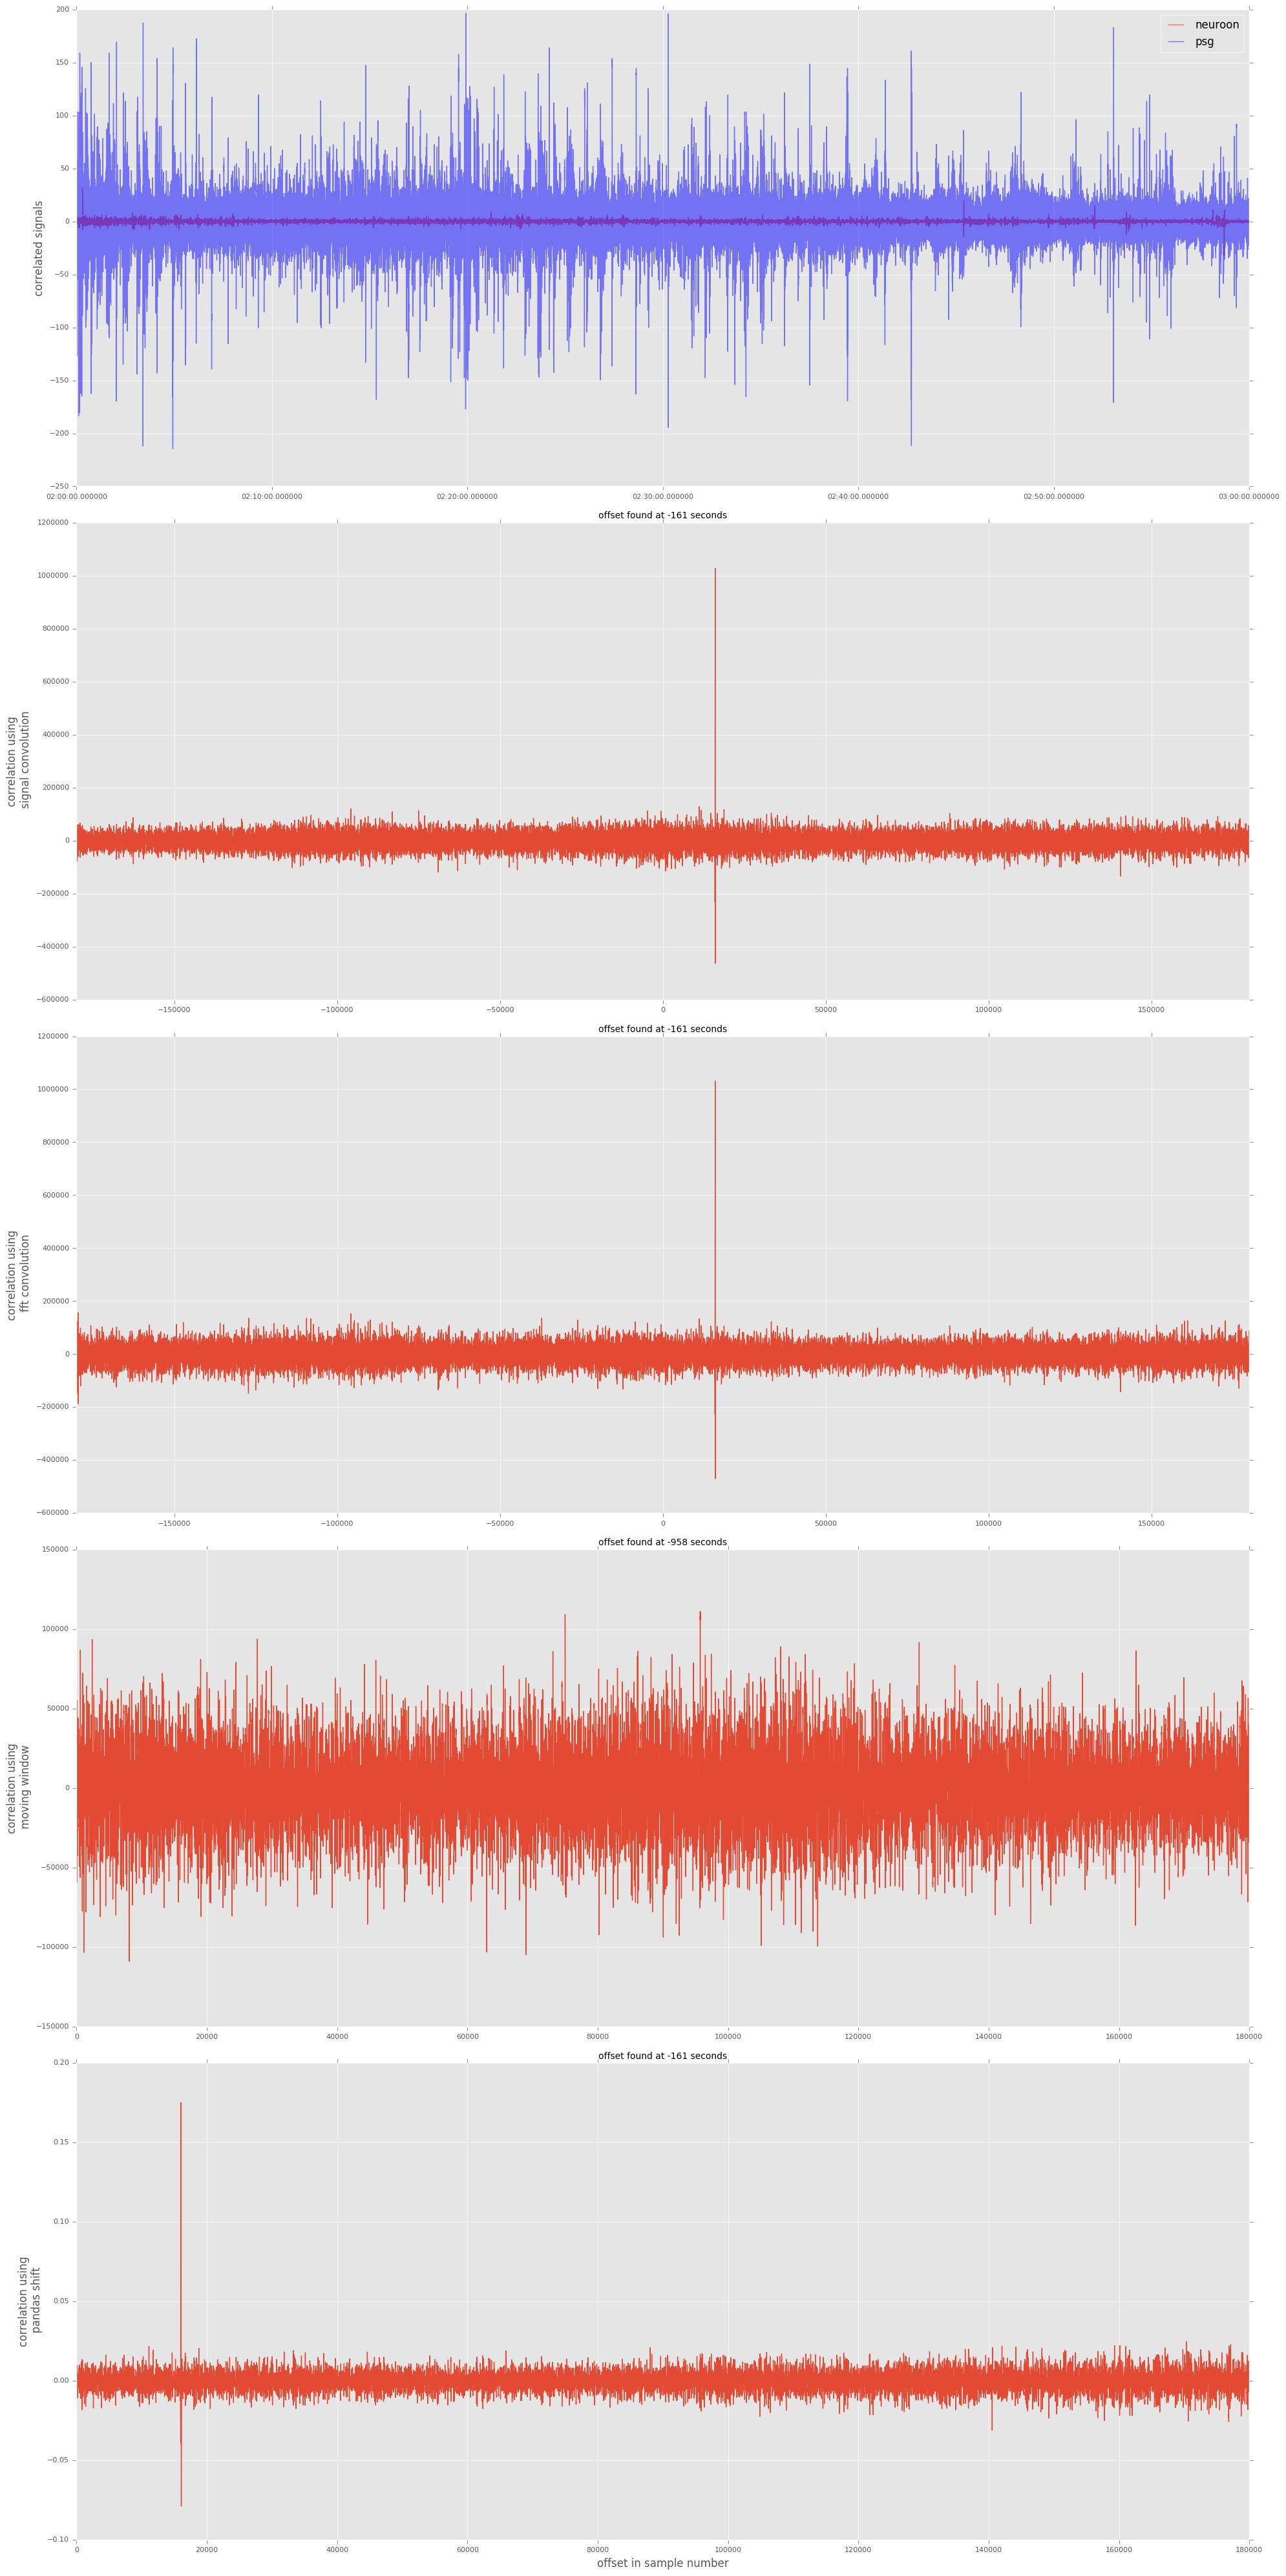

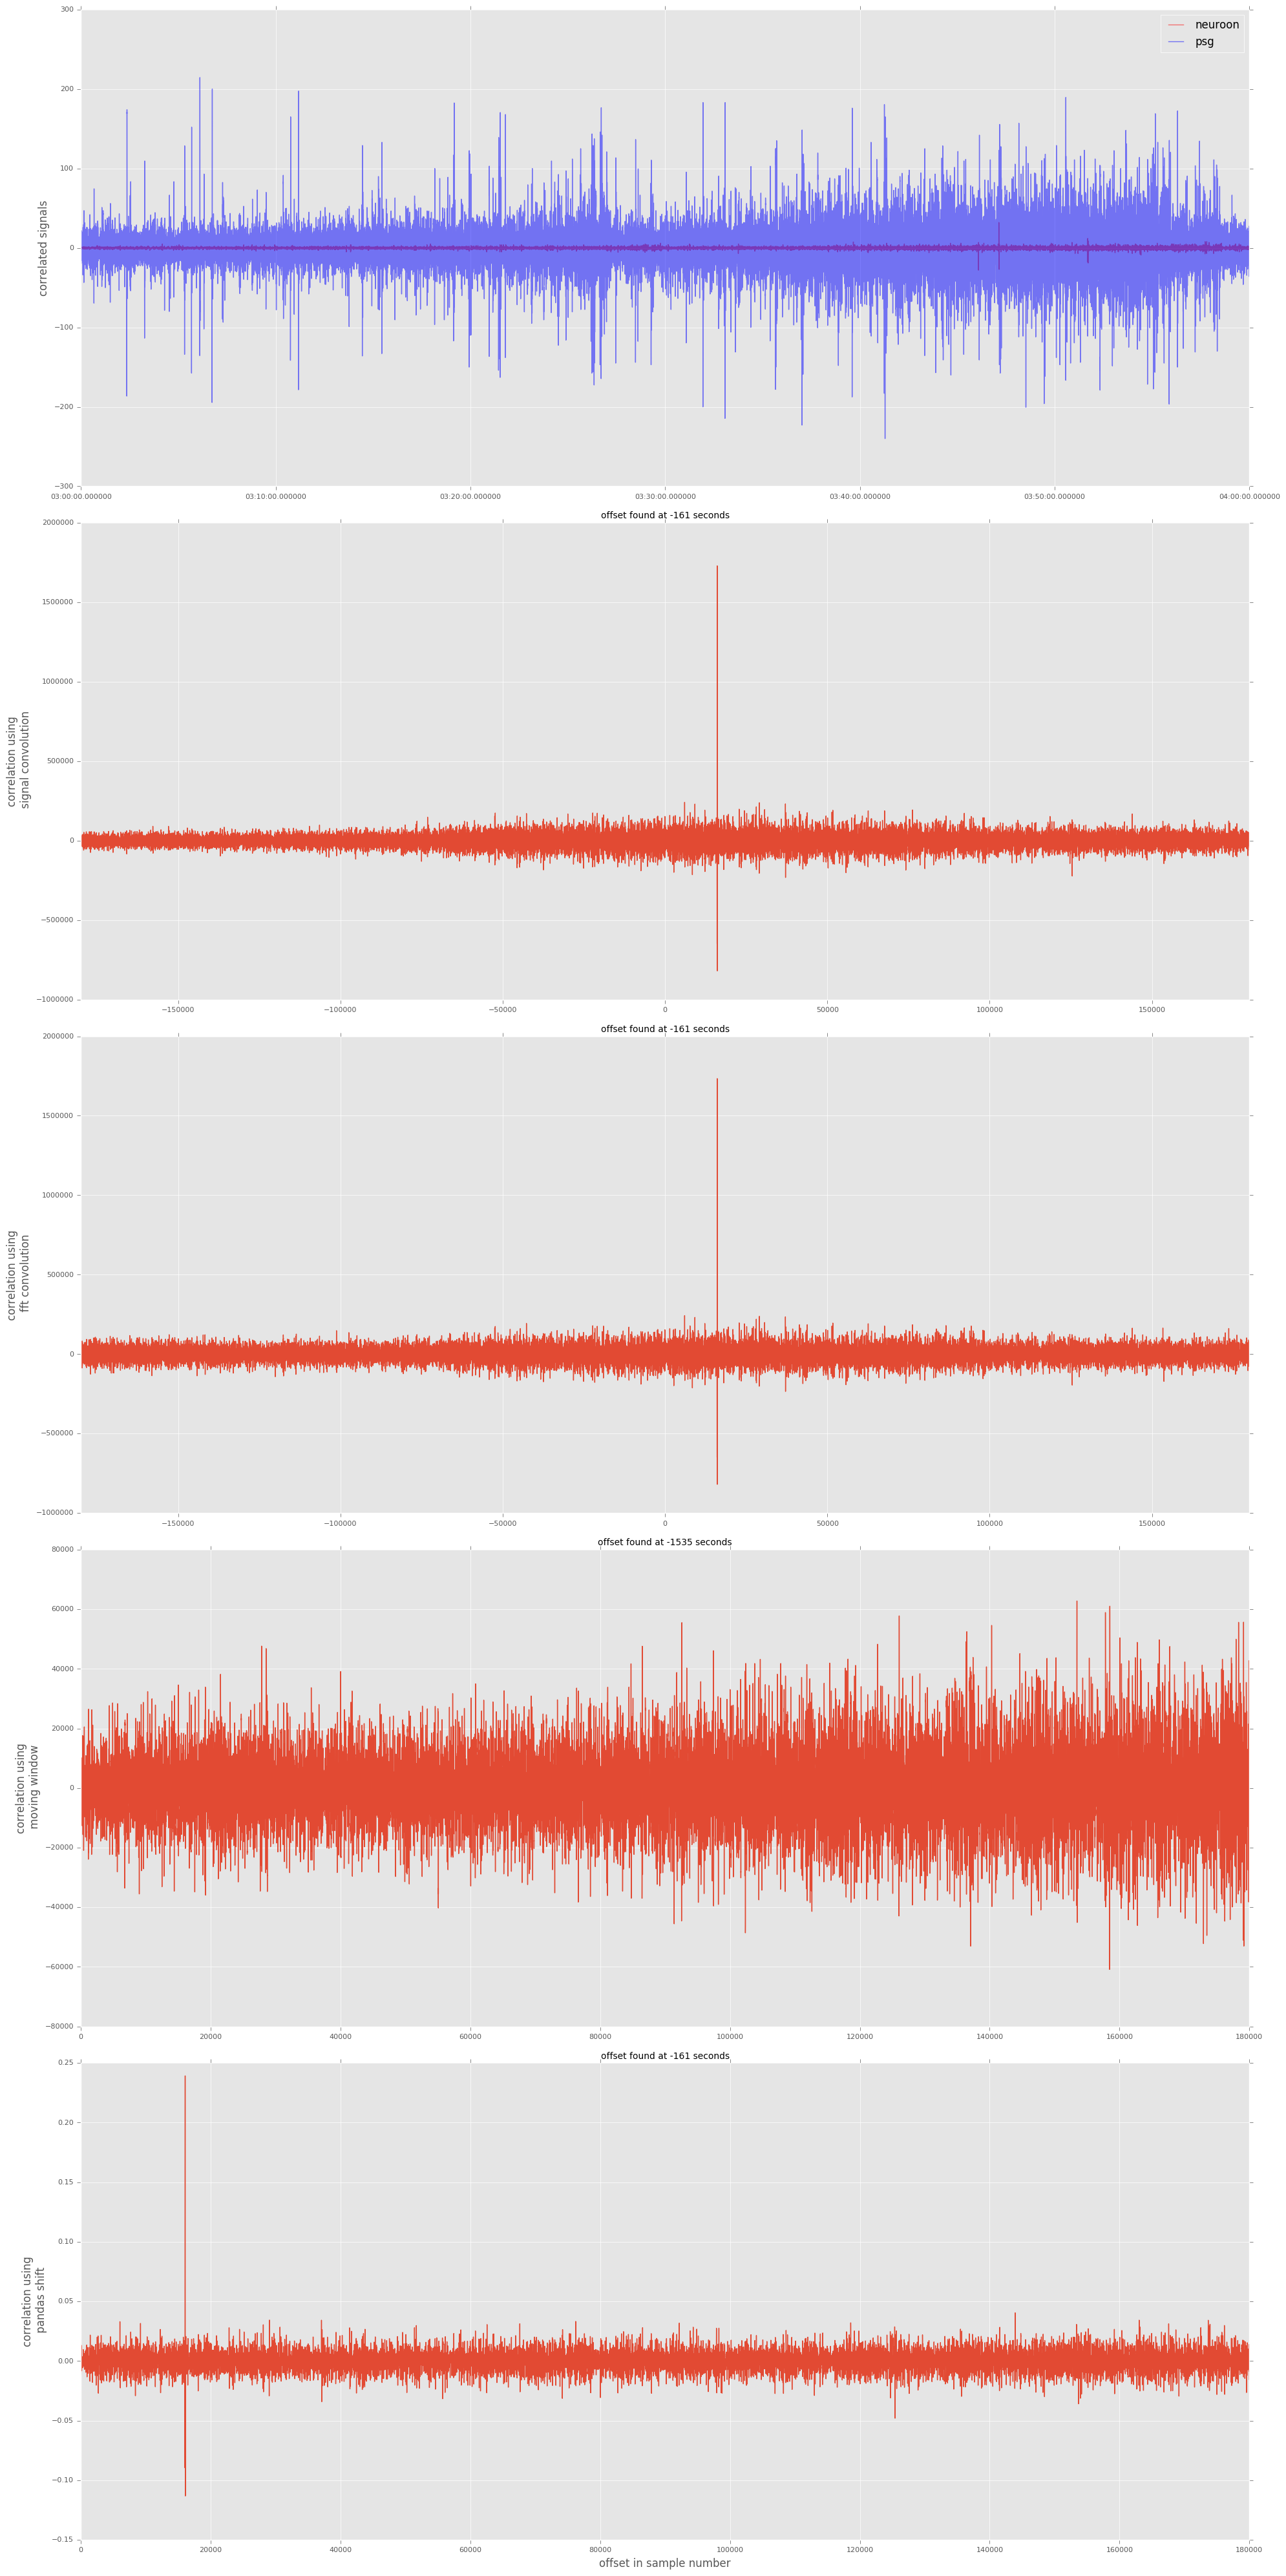

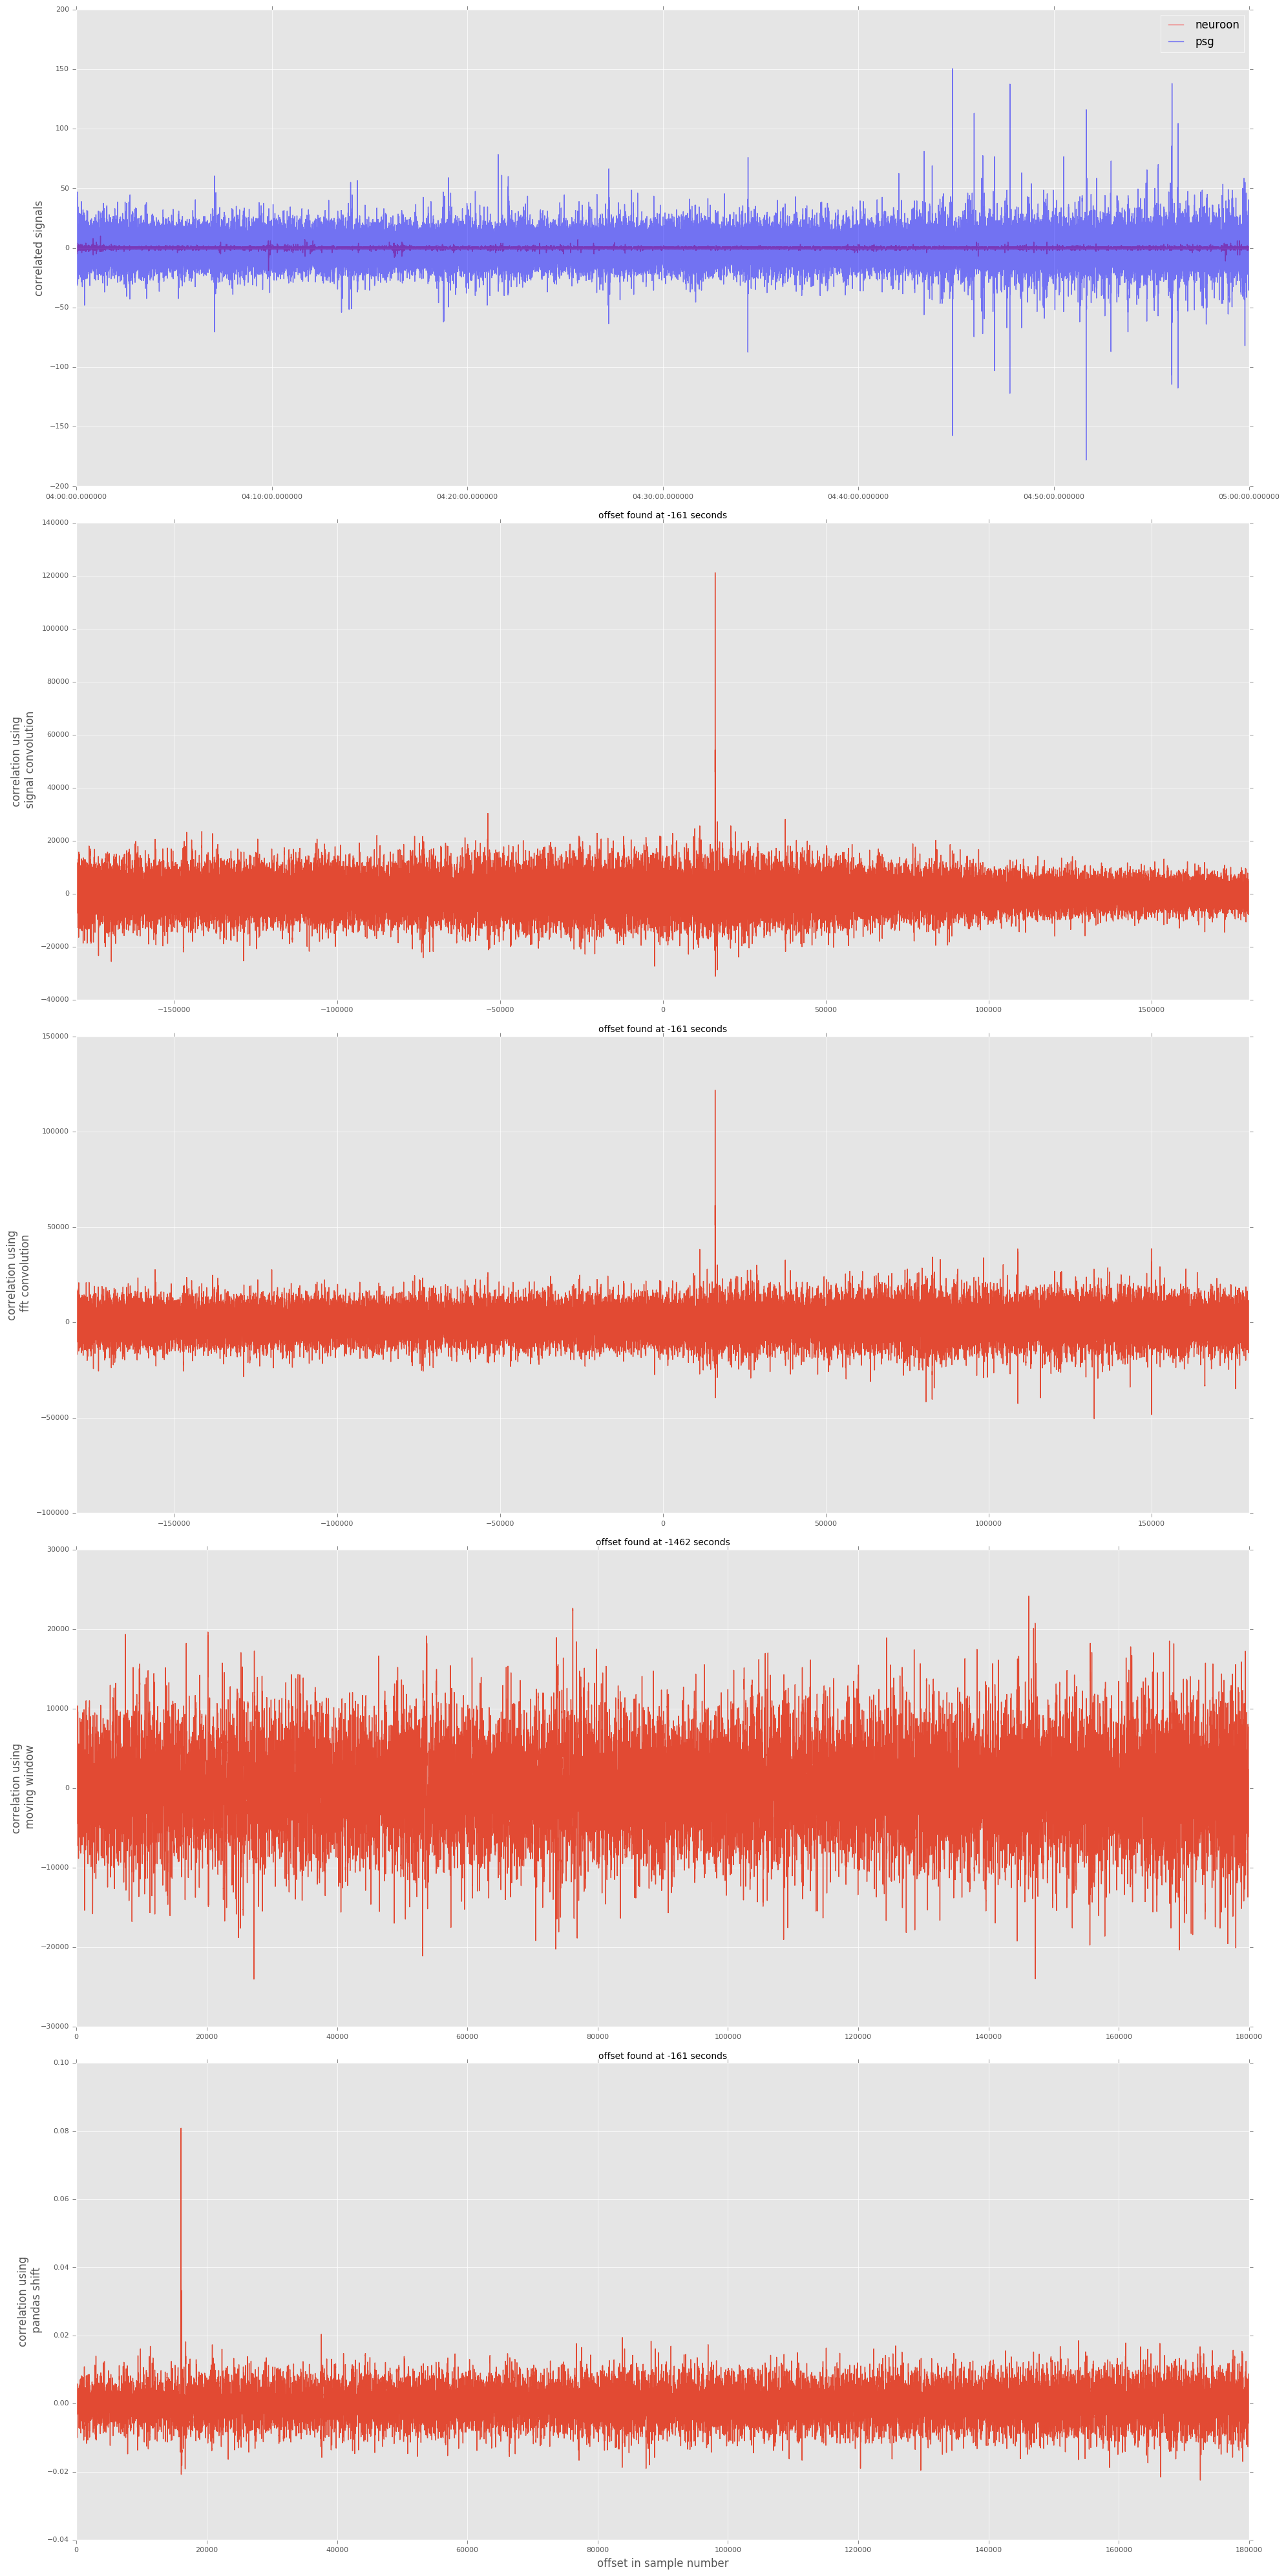

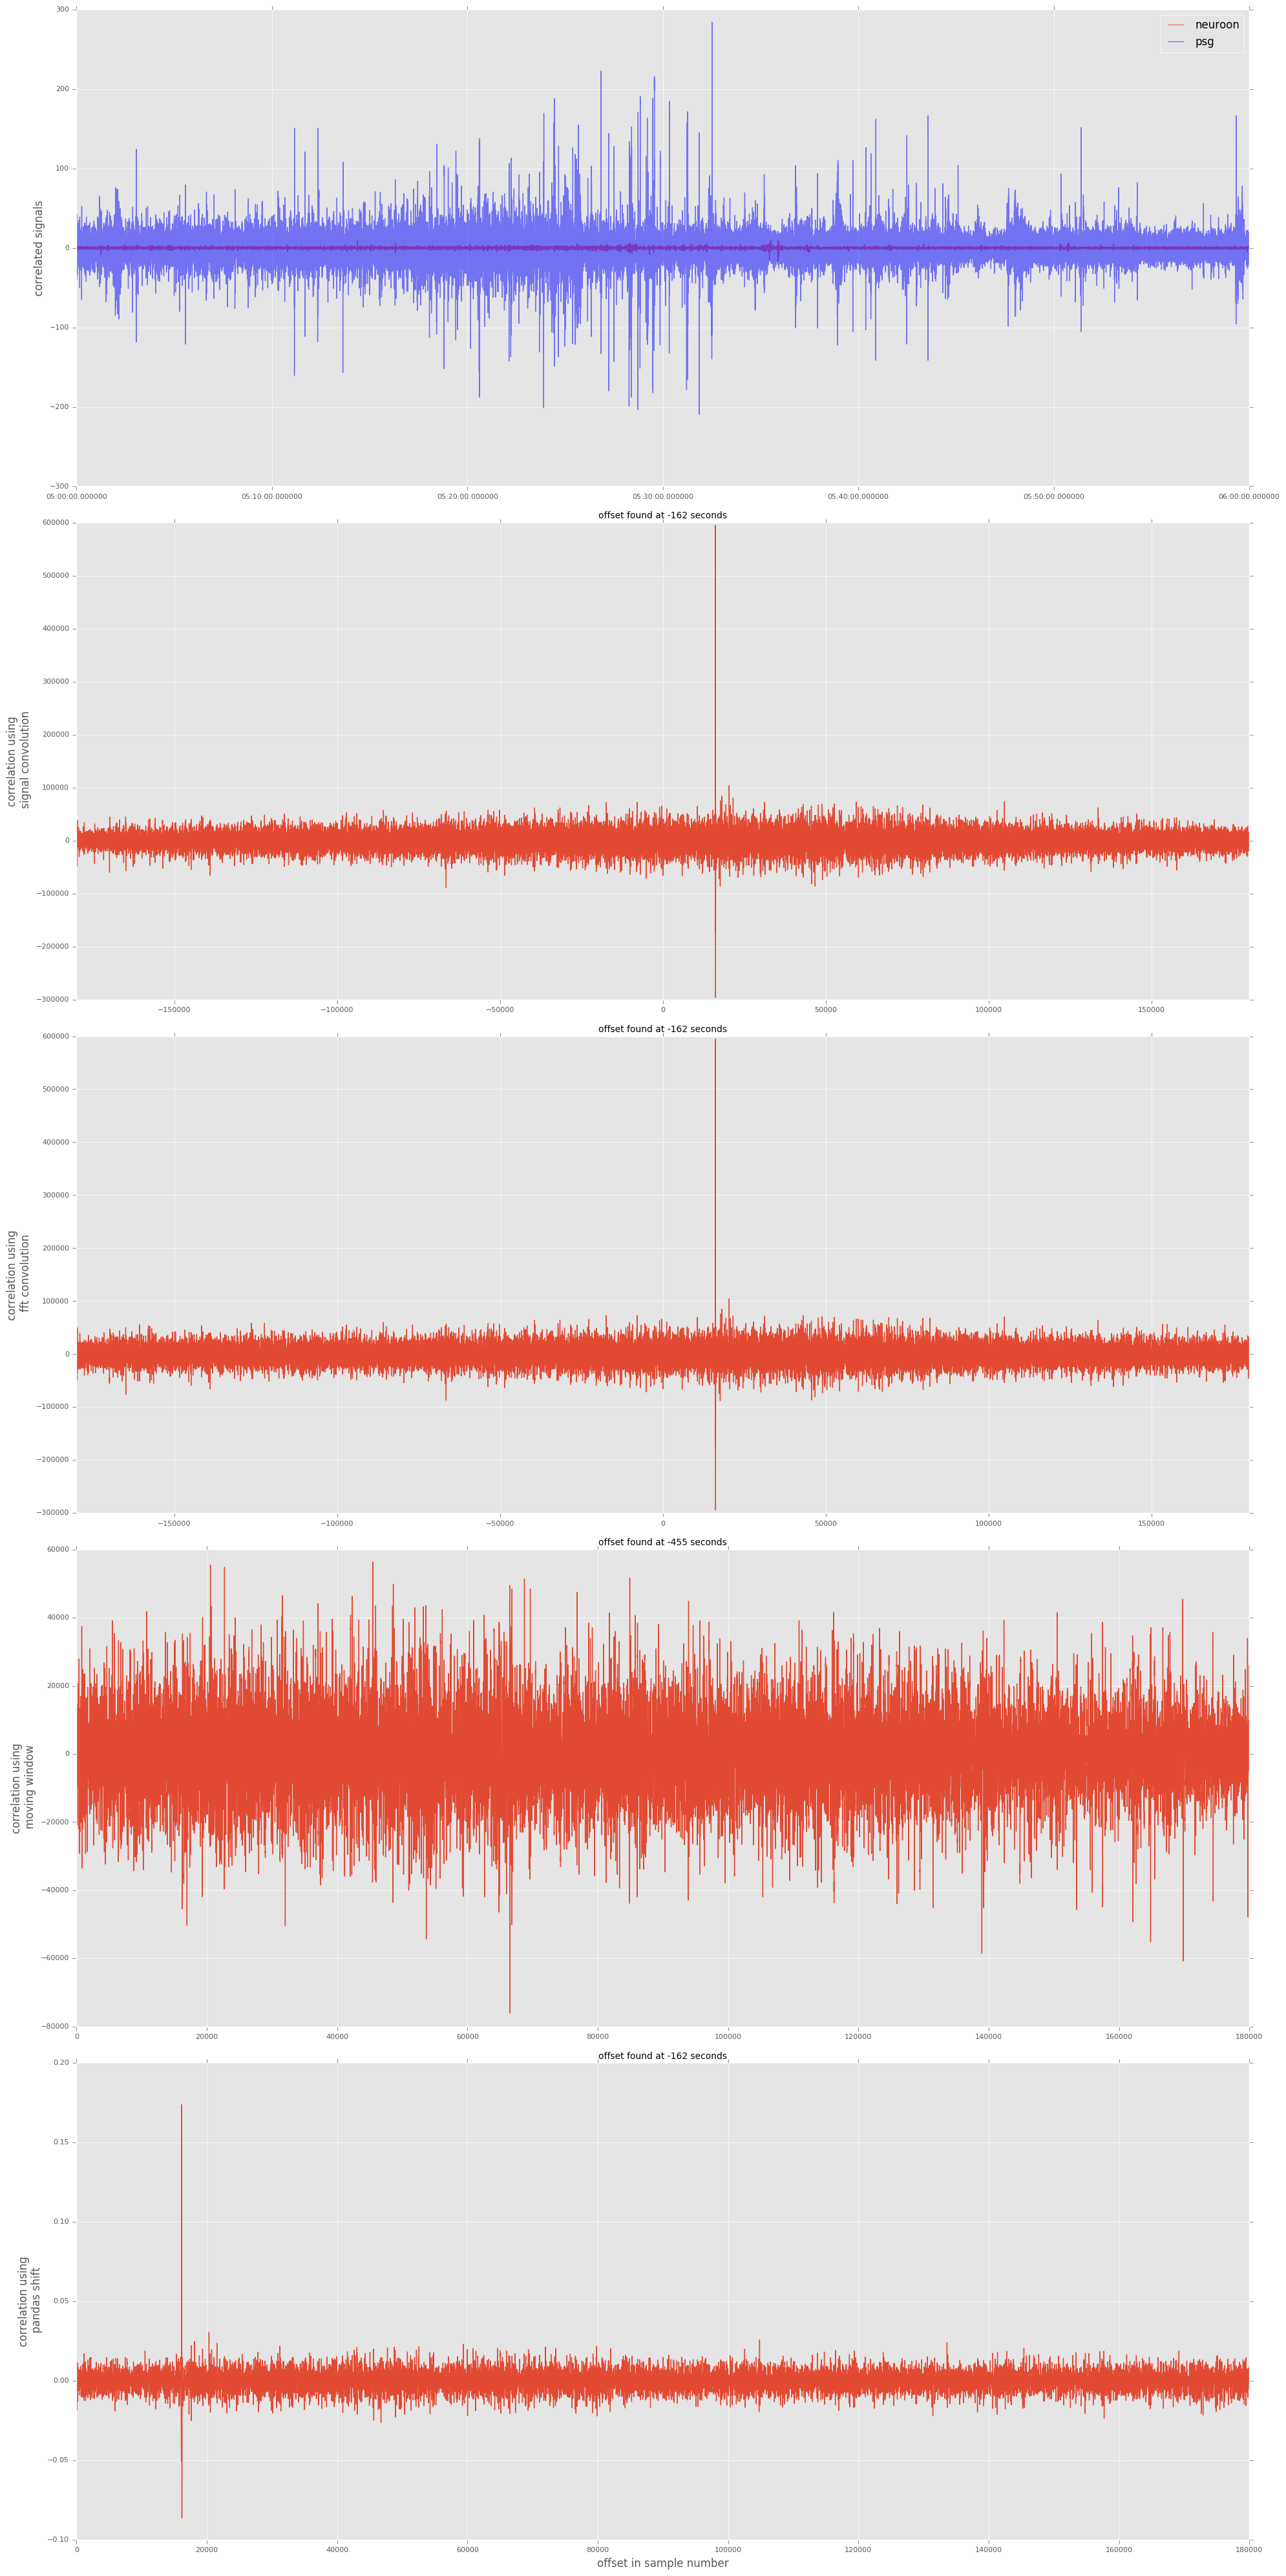

In [17]:
iterate_hours()